# Parsing the Hodgkin-Lymphoma screening data

In [1]:
import sys
sys.path.insert(0, '..')

### Parsing the RIS files

In [2]:
from pathlib import Path

PATH_PREFIX = "hodgkin_lymphoma"
GUIDELINE_ID = "hodgkin-lymphom"

PATH_GGPONC_LITERATURE = Path("../data/screening/ggponc_v2.1_2023_03_30_literature.csv")
PATH_RIS = Path(f"../data/screening/{PATH_PREFIX}/")
PATH_MANUAL_REVIEW = Path(f"../data/screening/{PATH_PREFIX}/manual_review.csv")
PATH_OUTPUT = Path(f"../data/screening/{PATH_PREFIX}/ris_with_matched_ids.csv")

PATH_LATEX_PLOT_OUTPUT = Path(
    f"../thesis/from_python/figures/experiments/{PATH_PREFIX}/"
)
PATH_LATEX_PLOT_OUTPUT.mkdir(parents=True, exist_ok=True)

In [3]:
import pandas as pd
import rispy
from evaluation.parsing import parse_kg_ris_file

In [4]:
df_ris = pd.concat(
    [parse_kg_ris_file(f, rispy.RisParser()) for f in PATH_RIS.rglob("*.txt")]
)

### Additional documents that were added at a later point

Some documents were placed behind paywalls and were only added to the search results at a later time. These include the following:

In [5]:
df_screened_later = pd.read_csv(
    PATH_RIS / "screened_later.csv",
    sep=";",
    dtype={"pm_id": "Int64"},
    usecols=["title", "doi", "pm_id"],
)
df_screened_later["path"] = PATH_RIS / "Included RCTs_HL only/rcts_added_later.txt"
df_screened_later["url"] = ""

In [6]:
df_screened_later

,title,doi,pm_id,path,url
0,Phase 2 Clinical Trial of Separation Surgery F...,10.1016/j.ijrobp.2021.07.1697,34715257,../data/screening/hodgkin_lymphoma/Included RC...,
1,Intensified treatment of patients with early s...,10.1016/S2352-3026(21)00029-6,33770483,../data/screening/hodgkin_lymphoma/Included RC...,
2,HL-507 First-Line Brentuximab Vedotin Plus Che...,10.1016/S2152-2650(22)01483-5,36164033,../data/screening/hodgkin_lymphoma/Included RC...,
3,Role of eHealth application Oncokompas in supp...,10.1016/S1470-2045(19)30675-8,31838009,../data/screening/hodgkin_lymphoma/Included RC...,
4,PET-guided omission of radiotherapy in early-s...,10.1016/S1470-2045(20)30601-X,33539742,../data/screening/hodgkin_lymphoma/Included RC...,
5,PET-guided eBEACOPP treatment of advanced-stag...,10.1016/S2352-3026(21)00101-0,34048679,../data/screening/hodgkin_lymphoma/Included RC...,
6,Brentuximab vedotin with chemotherapy for stag...,10.1016/S2352-3026(21)00102-2,34048680,../data/screening/hodgkin_lymphoma/Included RC...,


In [7]:
df_ris = pd.concat([df_ris, df_screened_later])

### Metadata Cleaning

In [8]:
df_ris["group"] = df_ris["path"].apply(lambda p: p.parent.stem)

In [9]:
df_ris["subgroup"] = df_ris["path"].apply(lambda p: p.stem)

In [10]:
df_ris["is_included"] = df_ris["group"].apply(
    lambda g: g.strip()
    in ["Included RCTs_HL only", "included SRs_HL only", "included SRs_mixed entities"]
)

In [11]:
df_ris["is_excluded"] = df_ris["is_included"] != True

In [12]:
import json

df_ris["exclusion_reason"] = df_ris.apply(
    lambda row: json.dumps({"group": row["group"], "subgroup": row["subgroup"]})
    if not row["is_included"]
    else "",
    axis=1,
)

In [13]:
df_ris["is_rct_ris"] = df_ris["group"].str.strip() == "Included RCTs_HL only"

In [14]:
from evaluation.parsing import parse_ris_date_to_datetime

df_ris["publication_date"] = parse_ris_date_to_datetime(
    df_ris, col_year="year", col_date="date"
)

In [15]:
import urllib

df_ris["url"] = df_ris["url"].apply(
    lambda s: urllib.parse.unquote(s, encoding="utf-8", errors="replace")
)

### Extracting Identifiers

In [16]:
from evaluation.parsing import REGEX

In [17]:
df_ris["nct_id"] = pd.NA
df_ris["cn_id"] = pd.NA
df_ris["doi_original"] = df_ris["doi"]
df_ris["doi"] = pd.NA

Some can be extracted from the `accession_number` column:

In [18]:
df_ris["pm_id"] = (
    df_ris["accession_number"].str.extract(REGEX["pm_id_start_end"]).astype("Int64")
)

Some additional Pubmed IDs are also found in the URL field:

In [19]:
df_ris["pm_id"] = df_ris["pm_id"].fillna(
    df_ris["url"].str.extract(REGEX["pm_id_from_query"])[0]
)

In [20]:
df_ris["cn_id"] = df_ris["url"].str.extract(REGEX["cn_id"])[0]

In [21]:
df_ris["doi"] = df_ris["doi_original"].str.extract(REGEX["doi"])

Some DOIs are hidden in the URL fields:

In [22]:
df_ris["doi"] = df_ris["doi"].fillna(
    df_ris["url"].str.extract(REGEX["doi_from_query"])[0]
)

We should also rename the ID column to reflect that it comes from the RIS files:

In [23]:
df_ris.rename(columns={"id": "ris_id"}, inplace=True)

### Identifier lookups

In [24]:
from integration.config import load_config
from integration.db import get_engine
from sqlalchemy.orm import sessionmaker

cfg = load_config("../config_v2.1_2023_03_30.ini")
engine = get_engine(cfg['DB']['url'])
session = sessionmaker(bind=engine)()

In [25]:
from integration.citation_utils import (
    get_title_to_id_mapping_pubmed,
    get_title_to_id_mapping_clinicaltrials,
)

df_pm = get_title_to_id_mapping_pubmed(session)
df_ct = get_title_to_id_mapping_clinicaltrials(session)

In [26]:
from tqdm.auto import tqdm
from integration.citation_utils import retrieve_all_identifiers
import os

tqdm.pandas(desc="Retrieving available identifiers")

df_ris = df_ris.progress_apply(  # type: ignore
    lambda row: retrieve_all_identifiers(
        row=row,
        entrez_email=os.environ.get("PUBMED_USER"),
        entrez_api_key=os.environ.get("PUBMED_API_KEY"),
        doi_pm_id_cache="../data/literature/doi_to_pm_id.json",
        cn_pm_id_cache="../data/literature/cn_id_to_pm_id.json",
        title_nct_id_cache="../data/literature/fuzzy_title_to_nct_id.json",
        title_pm_id_cache="../data/literature/fuzzy_title_to_pm_id.json",
        df_pm=df_pm,
        df_ct=df_ct,
    ),
    axis=1,
)
df_ris = df_ris.astype(
    {col: "Int64" for col in df_ris.columns if "pm_id" in col.lower()}
)

Retrieving available identifiers:   0%|          | 0/170 [00:00<?, ?it/s]

Potential mislabellings:

In [27]:
df_ris[
    [
        "title",
        "ris_id",
        "pm_id",
        "nct_id",
        "doi",
        "cn_id",
        "pm_id_doi",
        "pm_id_cn",
        "nct_id_cn",
        "pmc_id_cn",
        "nct_id_db",
        "pm_id_db",
    ]
].query(
    "pm_id_db.notnull() & pm_id.notnull() & pm_id != pm_id_db"
)  # .merge(df_pm, left_on="pm_id", right_on="pm_id", suffixes=("_ris", "_db"))  # to get correct title

,title,ris_id,pm_id,nct_id,doi,cn_id,pm_id_doi,pm_id_cn,nct_id_cn,pmc_id_cn,nct_id_db,pm_id_db


### Check if evidence is in the database

In [28]:
from evaluation.matching import is_in_db
from tqdm.auto import tqdm

tqdm.pandas(desc="Checking of evidence is in database")

db_pm_ids = set(df_pm["pm_id"])
db_nct_ids = set(df_ct["nct_id"])

df_ris = df_ris.progress_apply(
    lambda row: is_in_db(row=row, db_pm_ids=db_pm_ids, db_nct_ids=db_nct_ids), axis=1
)

Checking of evidence is in database:   0%|          | 0/170 [00:00<?, ?it/s]

### Retrieving Publication Types & Date

In [29]:
from tqdm.auto import tqdm
import os
from integration.citation_utils import pm_id_to_publication_types

tqdm.pandas(desc="Fetching article types")

df_ris["publication_types"] = df_ris["pm_id"].progress_apply(
    lambda pm_id: pm_id_to_publication_types(
        pm_id=pm_id,
        email=os.environ.get("PUBMED_USER"),
        api_key=os.environ.get("PUBMED_API_KEY"),
        cache_path="../data/literature/pm_id_to_entrez_xml.json",
    )
)

Fetching article types:   0%|          | 0/170 [00:00<?, ?it/s]

In [30]:
from integration.citation_utils import set_rct_flag

df_ris = df_ris.apply(set_rct_flag, axis=1)

In [31]:
from integration.citation_utils import pm_id_to_publication_date

tqdm.pandas(desc="Fetching article dates")

df_ris["article_date_api"] = pd.to_datetime(
    df_ris["pm_id"].progress_apply(
        lambda pm_id: pm_id_to_publication_date(
            pm_id=pm_id,
            email=os.environ.get("PUBMED_USER"),
            api_key=os.environ.get("PUBMED_API_KEY"),
            cache_path="../data/literature/pm_id_to_entrez_xml.json",
        )
    )
)

Fetching article dates:   0%|          | 0/170 [00:00<?, ?it/s]

Couldn't find article date for 32853585
Couldn't find article date for 30290903
Couldn't find article date for 32352505
Couldn't find article date for 34597375
Couldn't find article date for 31945149
Couldn't find article date for 33820822
Couldn't find article date for 35537731
Couldn't find article date for 31107282
Couldn't find article date for 31570470
Couldn't find article date for 35045567
Couldn't find article date for 31291126
Couldn't find article date for 30880807
Couldn't find article date for 36779325
Couldn't find article date for 33252698
Couldn't find article date for 31169526
Couldn't find article date for 34891715
Couldn't find article date for 33877657
Couldn't find article date for 30753270
Couldn't find article date for 32257153
Couldn't find article date for 35612839
Couldn't find article date for 31671178
Couldn't find article date for 33770483
Couldn't find article date for 33539742
Couldn't find article date for 34048679
Couldn't find article date for 34048680


### Presence in GGPONC

In [32]:
from evaluation.matching import is_in_ggponc
from tqdm.auto import tqdm

df_ggponc = (
    pd.read_csv(PATH_GGPONC_LITERATURE)
    .astype({"pm_id": "Int64"})
    .query("guideline_id == @GUIDELINE_ID")
)
ggponc_pm_ids = set(df_ggponc["pm_id"].dropna())
ggponc_titles = set(df_ggponc["title"])

tqdm.pandas(desc="Checking for presence in GGPONC")
df_ris = df_ris.progress_apply(
    lambda row: is_in_ggponc(
        row=row, ggponc_pm_ids=ggponc_pm_ids, ggponc_titles=ggponc_titles
    ),
    axis=1,
)

Checking for presence in GGPONC:   0%|          | 0/170 [00:00<?, ?it/s]

### Preparing final dataframe

For the final analyses, we need to deduplicate the data:

In [33]:
df_ris.sort_values(
    ["title", "pm_id", "nct_id", "cn_id", "doi", "is_included"], inplace=True
)

In [34]:
df_ris.drop_duplicates(
    ["title", "pm_id", "nct_id", "cn_id", "doi"], keep="last", inplace=True
)

In [35]:
n_non_null_pm_id_duplicates = len(
    df_ris[
        df_ris["pm_id"].duplicated(keep=False) & df_ris["pm_id"].notnull()
    ].sort_values(["pm_id", "is_included"], ascending=False)
)

print(
    f"There are {n_non_null_pm_id_duplicates} non-null PM ID duplicates in the dataset!"
)

There are 0 non-null PM ID duplicates in the dataset!


In [36]:
pd.crosstab(df_ris["is_included"], df_ris["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_included,,,
False,80,25,105
True,39,24,63
All,119,49,168


In [37]:
df_ris.query("is_included & is_rct_api & pm_id.isnull()")

,type_of_reference,abstract,accession_number,authors,number,keywords,file_attachments1,language,notes,year,...,nct_id_db,pm_id_db,is_in_db_pm,is_in_db_ct,is_in_db_title,is_in_db,publication_types,is_rct_api,article_date_api,is_in_ggponc


### Marking evidence as relevant

We consider everything that has been included OR that is in GGPONC as relevant:

In [38]:
df_ris.query("is_in_ggponc")[
    ["pm_id", "publication_date", "is_included", "is_rct_api", "group", "subgroup"]
]

,pm_id,publication_date,is_included,is_rct_api,group,subgroup
7,30827035,2019-03-01,False,False,excluded,ex_<50%:proportion of HL not reported
1,29224502,2017-01-01,True,True,Included RCTs_HL only,"first line, advanced (ECHELON-1)"
0,29229324,2018-01-01,True,True,Included RCTs_HL only,"first line_early stage, consolidation radiatio..."
0,30220622,2018-01-01,False,True,excluded,ex_non randomised
1,30290903,2018-01-01,True,True,Included RCTs_HL only,"first line, advanced"
0,31525824,2020-01-01,True,False,included SRs_HL only,"first line, all stages; Interim PET:prognosis"
3,30166329,2018-01-01,True,False,Included RCTs_HL only,"first line, advanced stage, PET"
0,31112475,2019-01-01,True,False,Included RCTs_HL only,"first line, early stage, PET"
1,31498753,2019-01-01,True,True,Included RCTs_HL only,"first line, early stage, PET"


In [39]:
df_ris["is_relevant"] = df_ris["is_included"] | df_ris["is_in_ggponc"]
df_ris["is_not_relevant"] = ~df_ris["is_relevant"]

In [40]:
pd.crosstab(df_ris["is_relevant"], df_ris["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_relevant,,,
False,79,24,103
True,40,25,65
All,119,49,168


### Manual Screening Results

We also have the results of the manual screening available. Although these were added after the original screening, we parse them at this point to reduce code duplication:

In [41]:
df_manual = pd.read_csv(PATH_MANUAL_REVIEW)
df_manual = (
    df_manual.query("source in ['Pubmed', 'Civic']")
    .astype({"pm_id": "Int64"})
    .rename(columns={"Ein- / Ausschlussgrund": "reason"})[
        ["pm_id", "publication_date", "reason", "is_included"]
    ]
)
df_manual["publication_date"] = pd.to_datetime(df_manual["publication_date"])
df_manual["is_excluded"] = ~df_manual["is_included"]
df_manual["is_relevant"] = df_manual["is_included"]
df_manual["is_not_relevant"] = df_manual["is_excluded"]
df_manual["exclusion_reason"] = df_manual.apply(lambda row: row["reason"] if row["is_excluded"] else pd.NA, axis=1)  # type: ignore
df_manual.drop(columns=["reason"], inplace=True)

# Since these records have been retrieved from the system before, we know that they are in the DB and that they are RCTs:
df_manual["publication_types"] = [[] for _ in range(len(df_manual))]
df_manual["is_in_db"] = True
df_manual["is_rct_api"] = True
df_manual["is_in_ggponc"] = False
df_manual["screening_origin"] = "manual"

In [42]:
df_ris["screening_origin"] = "original"

In [43]:
df_ris = pd.concat([df_ris, df_manual])

### Saving the output

In [44]:
df_ris.groupby(['screening_origin', 'is_relevant', 'is_rct_api']).size()

screening_origin  is_relevant  is_rct_api
manual            False        True          11
                  True         True           6
original          False        False         79
                               True          24
                  True         False         40
                               True          25
dtype: int64

In [45]:
from evaluation.parsing import save_parsed_ris_content

In [46]:
save_parsed_ris_content(
    df=df_ris,
    guideline_id="hodgkin-lymphom",
    guideline_name="Hodgkin's Lymphoma",
    csv_path=PATH_OUTPUT,
    cols_additional=["is_rct_ris"],
)

#### Sankey Diagram for thesis

In [47]:
df_ris_with_manual = df_ris

In [48]:
df_ris = df_ris.query("screening_origin == 'original'")

In [49]:
df_ris.is_included.value_counts()

False    105
True      63
Name: is_included, dtype: int64

In [50]:
df_ris_with_manual.groupby(['screening_origin', 'is_relevant', 'is_rct_api'])['pm_id'].count()

screening_origin  is_relevant  is_rct_api
manual            False        True          11
                  True         True           6
original          False        False         71
                               True          24
                  True         False         38
                               True          25
Name: pm_id, dtype: int64

In [51]:
relevant = df_ris.query("is_relevant")
relevant_rcts_api = relevant.query("is_rct_api")
relevant_other_api = relevant.query("~is_rct_api")

in_ggponc = df_ris.query("is_in_ggponc")
in_ggponc_rcts_api = in_ggponc.query("is_rct_api")
in_ggponc_other_api = in_ggponc.query("~is_rct_api")

inc = df_ris.query("is_included")
inc_ggponc = inc.query("is_in_ggponc")
inc_not_in_ggponc = df_ris.query("is_included & ~is_in_ggponc")
inc_not_in_ggponc_rcts_api = inc_not_in_ggponc.query("is_rct_api")
inc_not_in_ggponc_other_api = inc_not_in_ggponc.query("~is_rct_api")

unclear = df_ris.query("group == 'evtl included, nicht in Schlüsselfragen'")
unclear_ggponc = unclear.query("is_in_ggponc")
unclear_not_in_ggponc = unclear.query("~is_in_ggponc")

exc = df_ris.query("group == 'excluded'")
exc_ggponc = exc.query("is_in_ggponc")
exc_not_in_ggponc = exc.query("~is_in_ggponc")

In [52]:
nodes = [
    [("Full Text\nScreened", len(df_ris))],
    [
        ("Excluded", len(exc), {"label_pos": "top"}),
        ("Possibly\nIncluded\n(Not in RQ)", len(unclear), {"label_pos": "right"}),
        ("Included", len(inc), {"label_pos": "bottom"}),
    ],
    [
        ("Already\ncited in CPG", len(in_ggponc), {"label_pos": "bottom"}),
        ("Not\nin CPG", len(inc_not_in_ggponc), {"label_pos": "bottom"}),
    ],
    [
        ("RCTs", len(relevant_rcts_api), {"label_pos": "right"}),
        ("Other", len(relevant_other_api), {"label_pos": "right"}),
    ],
]

In [53]:
flows = [
    ("Full Text\nScreened", "Excluded", len(exc)),
    ("Full Text\nScreened", "Possibly\nIncluded\n(Not in RQ)", len(unclear)),
    ("Full Text\nScreened", "Included", len(inc)),
    ("Excluded", "Already\ncited in CPG", len(exc_ggponc)),
    ("Included", "Already\ncited in CPG", len(inc_ggponc)),
    ("Included", "Not\nin CPG", len(inc_not_in_ggponc)),
    ("Possibly\nIncluded\n(Not in RQ)", "Already\ncited in CPG", len(unclear_ggponc)),
    ("Already\ncited in CPG", "RCTs", len(in_ggponc_rcts_api)),
    ("Already\ncited in CPG", "Other", len(in_ggponc_other_api)),
    ("Not\nin CPG", "RCTs", len(inc_not_in_ggponc_rcts_api)),
    ("Not\nin CPG", "Other", len(inc_not_in_ggponc_other_api)),
]

/home/Florian.Borchert/miniconda3/envs/nge/lib/python3.10/site-packages/sankeyflow/sankeyflow.py:71: RuntimeWarning: invalid value encountered in scalar divide
  value_scale = self.value / (self.height - self.flow_pad * (len(flows) - 1))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

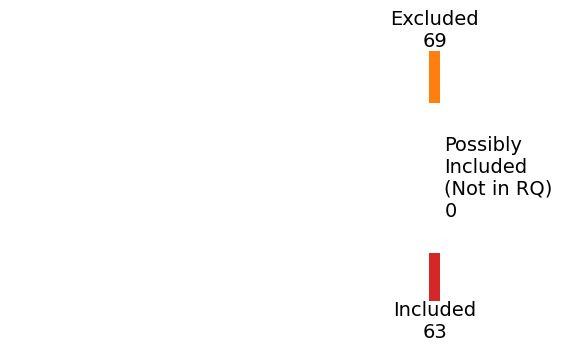

In [54]:
from sankeyflow import Sankey
from evaluation.plotting import set_size
import matplotlib.pyplot as plt

#plt.style.use("../thesis.mplstyle")

fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

s = Sankey(
    flow_color_mode="source",
    nodes=nodes,
    flows=flows,
    node_pad_y_min=0.3,
    align_y="tree",
    flow_color_mode_alpha=0.8,
)
s.draw(ax=ax)

fig.savefig(PATH_LATEX_PLOT_OUTPUT / "sankey_unique_per_step_reconstructed.pdf")